In [1]:
# Data packages
import pandas as pd 
import matplotlib.pyplot as plt

from tqdm import tqdm
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader

from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_recall_fscore_support, average_precision_score
from model.rnn import GRUDecoder
from model.autoencoder import SimpleAutoEncoder
from data_processing.pipeline import encoding_pipeline, get_generic_name

In [2]:
def get_device():
    # Check if CUDA is available
    if torch.cuda.is_available():
        # If CUDA is available, select the first CUDA device
        device = torch.device("cuda:0")
        print("Using CUDA device:", torch.cuda.get_device_name(0))
    # Check for MPS availability on supported macOS devices (requires PyTorch 1.12 or newer)
    elif torch.backends.mps.is_available():
        # If MPS is available, use MPS device
        device = torch.device("mps")
        print("Using MPS (Metal Performance Shaders) device")
    else:
        # Fallback to CPU if neither CUDA nor MPS is available
        device = torch.device("cpu")
        print("Using CPU")
    return device
device = get_device()

Using MPS (Metal Performance Shaders) device


# Read the data

Right now the notebook is set to work with fake data. This can be changed once the pipeline works.

The data is stored as a Dict[person_id, Sequences] where Sequences is a Dict[year, survery_wave_response]

In [3]:
# read in data and prepare transformations
data = pd.read_csv("data/training_data/PreFer_train_data.csv", low_memory=False)
targets = pd.read_csv('data/training_data/PreFer_train_outcome.csv')
codebook = pd.read_csv('data/codebooks/PreFer_codebook.csv')

### Select the top 10 most important questions (there's overlap, so there's only gonna be 8)

In [4]:
importance = pd.read_csv('features_importance_1000.csv')
custom_pairs = importance.feature.map(lambda x: get_generic_name(x)).unique()[:10]

In [5]:
# check if sequences have been preprocessed (saves time)
if False:# os.path.exists('data/processed_data/sequences.pt'):
    sequences = torch.load('data/processed_data/sequences.pt')
else:
    sequences = encoding_pipeline(data, codebook, custom_pairs=custom_pairs, importance=importance)
    #torch.save(sequences, 'data/processed_data/sequences.pt')

TypeError: encoding_pipeline() got an unexpected keyword argument 'importance'

# Train the SIMPLE Autoencoder

In [10]:
from model.dataset import PretrainingDataset
pretrain_dataset = PretrainingDataset(sequences)

In [7]:
### Initialization of the Autoencoder 
HIDDEN_DIM = 128
#ENCODING_SIZE = 64
BATCH_SIZE = 128
num_epochs_autoencoder = 1
learning_rate_autoencoder = 10e-2

SEQ_LEN = pretrain_dataset.get_seq_len()
vocab_size = pretrain_dataset.get_vocab_size()

train_dataloader = DataLoader(pretrain_dataset, batch_size=BATCH_SIZE, shuffle=True)
autoencoder = SimpleAutoEncoder(vocab_size=vocab_size, embedding_size=HIDDEN_DIM, sequence_len=SEQ_LEN).to(device)

#loss_f1 = nn.HuberLoss(delta=1.0)
loss_cls = nn.CrossEntropyLoss()
#loss_cos = nn.CosineEmbeddingLoss()
optimizer = optim.RAdam( autoencoder.parameters(), lr = learning_rate_autoencoder, weight_decay=1e-2, decoupled_weight_decay=True)
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max = num_epochs_autoencoder, eta_min = 1e-5, last_epoch = -1)

/opt/anaconda3/envs/eyra-rank/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### (or) Train the autoencoder

In [8]:
# Slows down the training but allows use to detect nan
DETECT_ANOMALY = False

In [9]:
""" INPUT MODEL NAME BELOW (FOR CHECKPOINTS)"""
model_name = "foo"

autoencoder.train()
autoencoder.to(device)
loss_metric = []
all_loss = []   # for plotting
######## ANNOMALY DETECTION
torch.autograd.set_detect_anomaly(DETECT_ANOMALY)

for epoch in range(num_epochs_autoencoder):
    loss_epoch_metric = []
    loop_object  = tqdm(enumerate(train_dataloader), desc=f"Epochs {epoch}")
    for i, (year, seq) in loop_object :
        optimizer.zero_grad()
        year = year.to(device)
        seq = seq.to(device)
        
        nan_index = seq == 101

        x = autoencoder(year, seq)
        loss = loss_cls(x.permute(0,2,1), seq.long()) #+ #+ loss_cos(x1.reshape(x1.size(1) * x1.size(0), -1 ), 
                                                       #         autoencoder.embedding(year, seq).view(x1.size(1) * x1.size(0), -1), 
                                                        #        torch.ones(seq.size(0) * seq.size(1)).to(device))
         #+ 0.7 * loss_f1(x1, autoencoder.embedding(year, seq)) +  
        loss_epoch_metric.append(loss.detach().cpu().numpy())
        all_loss.append(loss_epoch_metric[-1])
        loss.backward()
        optimizer.step()
        loop_object.set_postfix_str("mean loss: %.5f"%np.mean(loss_epoch_metric[-100:]))
    ## After epoch end
    scheduler.step()
    loss_metric.append(np.mean(loss_epoch_metric))
    print(f'epoch {epoch} \t Loss: {loss_metric[-1]:.4g} and LR: {scheduler.get_last_lr()[0]:.5g}')
    torch.save(autoencoder.state_dict(), f'weights/{model_name}_{epoch}.pt')

Epochs 0: 11it [00:10,  1.02it/s, mean loss: 3.53300]

epoch 0 	 Loss: 3.533 and LR: 1e-05


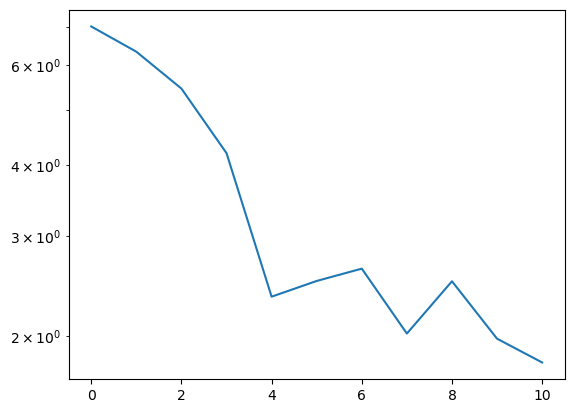

In [11]:
plt.plot(all_loss)

plt.yscale('log')
plt.show()

### Explroe the embedding space

In [12]:
### FAST CHECK
print("Answer Embedding has %s NaNs" %torch.isnan(autoencoder.embedding.answer_embedding.weight).sum().cpu().numpy())
print("Year Embedding has %s NaNs" %torch.isnan(autoencoder.embedding.yearly_embedding.weight).sum().cpu().numpy())

Answer Embedding has 0 NaNs
Year Embedding has 0 NaNs


In [13]:
#import umap
import umap.umap_ as umap
import matplotlib.pyplot as plt
w = autoencoder.embedding.answer_embedding.weight.detach().cpu().numpy()
projector = umap.UMAP(n_components=2)
wp = projector.fit_transform(w)
plt.scatter(wp[:,0], wp[:,1])
plt.show()

OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


# Train the RNN

First we need to create Dataset class that can hold both the target (stored in a pd.DataFrame) and the sequences.

The sequences will be of dimension 14 x encoding_dimension, because we have 14 years of surveys.

I have created some code for getting the data into the right format, but it might not be useful.

## Regarding masks
Right now the masking is done already in the encoding. I haven't found exactly where Mikkel implemented this.
So for now, assume that nothing is padded, and then we'll figure it out with Mikkel.

In [46]:
# its not everyone we have a target for, so we do restrict the data to 
# the ones with known outcomes
targets = targets[targets.new_child.notna()]
train_person_ids, test_person_ids = train_test_split(targets['nomem_encr'], test_size=0.2, random_state=42)

In [28]:
rnn_data = {person_id: (
        torch.tensor([year-2007 for year, _ in wave_responses.items()]).to(device),
        torch.tensor([ wave_response for _, wave_response in wave_responses.items()]).to(device)
        )
        for person_id, wave_responses in sequences.items()
}

In [29]:
# split data based on the splits made for the target
train_data = {person_id: rnn_data[person_id] for person_id in train_person_ids}
test_data = {person_id: rnn_data[person_id] for person_id in test_person_ids}

In [30]:
from model.dataset import FinetuningDataset
train_dataset = FinetuningDataset(train_data, targets = targets)
test_dataset = FinetuningDataset(test_data, targets = targets)

rnn_batch_size = 16

train_dataloader = DataLoader(train_dataset, batch_size=rnn_batch_size, shuffle=True)
test_dataloader  = DataLoader(test_dataset,  batch_size=rnn_batch_size)

In [31]:
# ft - fine-tuning
ENCODING_SIZE = 64
HIDDEN_SIZE = 64

num_epochs_ft = 1
learning_rate_ft = 5e-3

aggregator = nn.Sequential(
    nn.LazyInstanceNorm1d(),
    nn.LazyLinear(ENCODING_SIZE),
    nn.LazyBatchNorm1d()).to(device)

######## WHAT we used initialy
#decoder = GRUDecoder(
#    input_size=ENCODING_SIZE,
#    hidden_size=HIDDEN_SIZE,
#    max_seq_len=14
#).to(device)

#### Simple RNN
decoder = GRUDecoder(
    input_size=ENCODING_SIZE,
    hidden_size=HIDDEN_SIZE,
    max_seq_len=14,
    dropout=0.15,
    bidirectional= False, 
    num_layers=2,
    with_attention= True
).to(device)


##### SIMPLE DECODER with AVERGING (no reccurences or attention)
#decoder = SimpleDecoder(input_size=ENCODING_SIZE, output_size=1).to(device)

# Define loss function and optimizer for RNN
ft_loss = torch.nn.BCELoss()
ft_optimizer = torch.optim.RAdam(list(decoder.parameters()) + list(autoencoder.parameters()) + list(aggregator.parameters()) , 
                                                                   lr=learning_rate_ft, 
                                                                   weight_decay=1e-3, 
                                                                   decoupled_weight_decay=True)
ft_scheduler = optim.lr_scheduler.CosineAnnealingLR(ft_optimizer, T_max = num_epochs_ft, eta_min = 1e-6, last_epoch = -1)

# Training loop
decoder.train()
autoencoder.train()
aggregator.train()
print("Ready!")

Ready!


/opt/anaconda3/envs/eyra-rank/lib/python3.11/site-packages/torch/nn/modules/lazy.py:181: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


In [32]:
NUM_COLS = 44

In [53]:
loss_per_epoch = []
for epoch in range(num_epochs_ft):
    # print(epoch)
    loss_per_step = []
    loop_object  = tqdm(enumerate(train_dataloader), desc=f"Epochs {epoch}")
    for i, batch in loop_object :        
        ft_optimizer.zero_grad() 
        inputs, labels = batch
        labels = labels.to(torch.float).to(device)

        input_year, input_seq = inputs
        bs, ss = labels.size(0), 14
        input_year = input_year.reshape(-1).to(device)
        input_seq = input_seq.reshape(bs * ss, -1).to(device)

        encodings = autoencoder.get_encoding(input_year, input_seq).view(bs,ss, -1)
        encodings = aggregator(encodings) # make sure that the number of dimensions is aligned after the Simple Decoder
        mask = ~((input_seq == 101).sum(-1) == NUM_COLS).view(bs,ss).detach()

        # Forward pass
        xx = decoder(encodings, mask)
        outputs = F.sigmoid(xx)

        loss = ft_loss(torch.flatten(outputs), labels)  
        loss_per_step.append(loss.detach().cpu().numpy())
        loop_object.set_postfix_str("mean loss: %.3f"%np.mean(loss_per_step[-100:]))

        #loss.backward(retain_graph=True)
        loss.backward()
        ft_optimizer.step()
    # On epoch end
    loss_per_epoch.append(np.mean(loss_per_step))
    ft_scheduler.step()

    print(f"Epoch {epoch+1}/{num_epochs_ft}, Loss: {loss_per_epoch[-1]:.4f}")
    

Epochs 0: 0it [00:00, ?it/s]


RuntimeError: shape '[224, -1]' is invalid for input of size 1664

In [34]:

val_loss = []
preds = []
targets = []

## Set both models into the eval mode.=
decoder.eval()
autoencoder.eval()
aggregator.eval()
for batch in test_dataloader:
    inputs, labels = batch
    labels = labels.to(torch.float).to(device)

    input_year, input_seq = inputs
    bs, ss = labels.size(0), 14
    input_year = input_year.reshape(-1).to(device)
    input_seq = input_seq.reshape(bs * ss, -1).to(device)

    encodings = autoencoder.get_encoding(input_year, input_seq).view(bs,ss, -1)
    encodings = aggregator(encodings)
    mask = ~((input_seq == 101).sum(-1) == NUM_COLS).view(bs,ss).detach()


    # Forward pass
    xx = decoder(encodings, mask)
    outputs = torch.nn.functional.sigmoid(xx).flatten()
    loss = ft_loss(outputs, labels)  
    val_loss.append(loss.detach().cpu().numpy())
    preds.extend(outputs.detach().cpu().numpy().tolist())
    targets.extend(labels.cpu().numpy().tolist())

In [35]:
# Concatenate all the batches
predictions = (torch.tensor(preds) > 0.5).float()
probs = F.sigmoid(predictions)
actuals = torch.tensor(targets).flatten()

# Calculate precision, recall, and F1 score
precision, recall, f1, _ = precision_recall_fscore_support(actuals.cpu().numpy(), predictions.cpu().numpy(), average='binary')
map_roc = average_precision_score(actuals.numpy(), probs.numpy())
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")
print(f"-- mAP Score: {map_roc:.4f} --")

Precision: 0.0000
Recall: 0.0000
F1 Score: 0.0000
-- mAP Score: 0.2525 --


/opt/anaconda3/envs/eyra-rank/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


# What is the effect of increasing the vocabulary

In [4]:
from model.dataset import PretrainingDataset
from model.dataset import FinetuningDataset

In [5]:
def pretrain(pt_epochs, train_dataloader, autoencoder, optimizer_pt, loss_pt, scheduler_pt):
    for epoch in range(pt_epochs):

        loop_object  = tqdm(enumerate(train_dataloader), desc=f"Epochs {epoch}")
        for i, (year, seq) in loop_object :
            optimizer_pt.zero_grad()
            year = year.to(device)
            seq = seq.to(device)
            
            x = autoencoder(year, seq)
            loss = loss_pt(x.permute(0,2,1), seq.long())
                                                            
            loss.backward()
            optimizer_pt.step()
        ## After epoch end
        scheduler_pt.step()
        

def finetune(num_epochs_ft, train_dataloader, autoencoder, decoder, ft_loss, ft_optimizer, aggregator, num_cols):
    for epoch in range(num_epochs_ft):
        # print(epoch)
        loop_object  = tqdm(enumerate(train_dataloader), desc=f"Epochs {epoch}")
        for i, batch in loop_object :        
            ft_optimizer.zero_grad() 
            inputs, labels = batch
            labels = labels.to(torch.float).to(device)

            input_year, input_seq = inputs
            bs, ss = labels.size(0), 14
            input_year = input_year.reshape(-1).to(device)
            input_seq = input_seq.reshape(bs * ss, -1).to(device)

            encodings = autoencoder.get_encoding(input_year, input_seq).view(bs,ss, -1)
            encodings = aggregator(encodings) # make sure that the number of dimensions is aligned after the Simple Decoder
            mask = ~((input_seq == 101).sum(-1) == num_cols).view(bs,ss).detach()

            # Forward pass
            xx = decoder(encodings, mask)
            outputs = F.sigmoid(xx)

            loss = ft_loss(torch.flatten(outputs), labels)  

            #loss.backward(retain_graph=True)
            loss.backward()
            ft_optimizer.step()

In [6]:
def evaluate(dataloader, encoder, decoder, num_cols, aggregator):
    val_loss = []
    preds = []
    targets = []

    ## Set both models into the eval mode
    decoder.eval()
    encoder.eval()
    for batch in dataloader:
        inputs, labels = batch
        labels = labels.to(torch.float).to(device)

        input_year, input_seq = inputs
        bs, ss = labels.size(0), 14
        input_year = input_year.reshape(-1).to(device)
        input_seq = input_seq.reshape(bs * ss, -1).to(device)

        encodings = encoder.get_encoding(input_year, input_seq).view(bs,ss, -1)
        encodings = aggregator(encodings) # make sure that the number of dimensions is aligned after the Simple Decoder
        mask = ~((input_seq == 101).sum(-1) == num_cols).view(bs,ss).detach()

        # Forward pass
        xx = decoder(encodings, mask)
        outputs = torch.nn.functional.sigmoid(xx).flatten()
        loss = ft_loss(outputs, labels)  
        val_loss.append(loss.detach().cpu().numpy())
        preds.extend(outputs.detach().cpu().numpy().tolist())
        targets.extend(labels.cpu().numpy().tolist())


    # Concatenate all the batches
    predictions = (torch.tensor(preds) > 0.5).float()
    probs = F.sigmoid(predictions)
    actuals = torch.tensor(targets).flatten()

    # Calculate precision, recall, and F1 score
    precision, recall, f1, _ = precision_recall_fscore_support(actuals.cpu().numpy(), predictions.cpu().numpy(), average='binary')
    map_roc = average_precision_score(actuals.numpy(), probs.numpy())
    
    return precision, recall, f1, map_roc

In [63]:
PT_HIDDEN_DIM=128
PT_BATCH_SIZE=128
PT_NUM_EPOCHS=5
PT_LEARNING_RATE=10e-2

FT_BATCH_SIZE = 16
FT_ENCODING_SIZE = 64
FT_HIDDEN_SIZE = 64

FT_NUM_EPOCHS= 10
FT_LEARNING_RATE= 5e-3
n_questions = [50, 250, 500, 750, 1000]
reps = 3

importance = pd.read_csv('features_importance_1000.csv')
targets = targets[targets.new_child.notna()].reset_index(drop=True)

In [64]:
prec_list = []
rec_list = []
f1_list = []
train_prec_list = []
train_rec_list = []
train_f1_list = []

n_question_list = []
n_col_list = []

train_person_ids, test_person_ids = train_test_split(targets['nomem_encr'], test_size=0.2, random_state=42)

for n_question in n_questions:
    print(n_question)
    custom_pairs = importance.iloc[:n_question].feature.map(lambda x: get_generic_name(x))

    sequences = encoding_pipeline(data, codebook, custom_pairs=custom_pairs)
    pretrain_dataset = PretrainingDataset(sequences)
    

    for rep in range(reps):

        # initialize autoencoder and pretrain    
        SEQ_LEN = pretrain_dataset.get_seq_len()
        vocab_size = pretrain_dataset.get_vocab_size()

        pt_dataloader = DataLoader(pretrain_dataset, batch_size=PT_BATCH_SIZE, shuffle=True)
        autoencoder = SimpleAutoEncoder(vocab_size=vocab_size, embedding_size=PT_HIDDEN_DIM, sequence_len=SEQ_LEN).to(device)
        autoencoder.train()
        autoencoder.to(device)

        pt_loss_cls = nn.CrossEntropyLoss()
        pt_optimizer = optim.RAdam(autoencoder.parameters(), lr = PT_LEARNING_RATE, weight_decay=1e-2, decoupled_weight_decay=True)
        pt_scheduler = optim.lr_scheduler.CosineAnnealingLR(pt_optimizer, T_max = PT_NUM_EPOCHS, eta_min = 1e-5, last_epoch = -1)

        autoencoder.train()
        pretrain(pt_epochs=PT_NUM_EPOCHS,
            train_dataloader=pt_dataloader,
            autoencoder=autoencoder,
            loss_pt=pt_loss_cls,
            optimizer_pt=pt_optimizer,
            scheduler_pt=pt_scheduler,
            )
        autoencoder.eval()

        # initialize GRU and perform fine-tuning    

        rnn_data = {
            person_id: (
                torch.tensor([year-2007 for year, _ in wave_responses.items()]).to(device),
                torch.tensor([wave_response for _, wave_response in wave_responses.items()]).to(device)
                )
                for person_id, wave_responses in sequences.items()
        }

        train_data = {person_id: rnn_data[person_id] for person_id in train_person_ids}
        test_data = {person_id: rnn_data[person_id] for person_id in test_person_ids}

        train_dataset = FinetuningDataset(train_data, targets = targets)
        test_dataset = FinetuningDataset(test_data, targets = targets)

        train_dataloader = DataLoader(train_dataset, batch_size=FT_BATCH_SIZE, shuffle=True)
        test_dataloader  = DataLoader(test_dataset,  batch_size=FT_BATCH_SIZE)

        aggregator = nn.Sequential(
            nn.LazyInstanceNorm1d(),
            nn.LazyLinear(FT_ENCODING_SIZE),
            nn.LazyBatchNorm1d()).to(device)

        decoder = GRUDecoder(
            input_size=FT_ENCODING_SIZE,
            hidden_size=FT_HIDDEN_SIZE,
            max_seq_len=14,
            dropout=0.15,
            bidirectional= False, 
            num_layers=2,
            with_attention= True
        ).to(device)

        # Define loss function and optimizer for RNN
        ft_loss = torch.nn.BCELoss()
        ft_optimizer = torch.optim.RAdam(list(decoder.parameters()) + list(autoencoder.parameters()) + list(aggregator.parameters()) , 
                                                                           lr=FT_LEARNING_RATE, 
                                                                           weight_decay=1e-3, 
                                                                           decoupled_weight_decay=True)
        ft_scheduler = optim.lr_scheduler.CosineAnnealingLR(ft_optimizer, T_max = FT_NUM_EPOCHS, eta_min = 1e-6, last_epoch = -1)

        # Training loop
        decoder.train()
        aggregator.train()
        
        NUM_COLS = next(iter(train_dataloader))[0][1].shape[-1]
        finetune(
            num_epochs_ft=FT_NUM_EPOCHS,
            train_dataloader=train_dataloader,
            autoencoder=autoencoder,
            ft_loss=ft_loss,
            ft_optimizer=ft_optimizer,
            decoder=decoder,
            aggregator=aggregator,
            num_cols=NUM_COLS
        )
        
        precision, recall, f1, map_roc = evaluate(dataloader=test_dataloader,
                                                encoder=autoencoder,
                                                decoder=decoder,
                                                num_cols=NUM_COLS,
                                                aggregator=aggregator)
        precision_train, recall_train, f1_train, map_roc_train = evaluate(dataloader=train_dataloader,
                                                                          encoder=autoencoder,
                                                                          decoder=decoder,
                                                                          num_cols=NUM_COLS,
                                                                          aggregator=aggregator
                                                                          )
        
        prec_list.append(precision)
        rec_list.append(recall)
        f1_list.append(f1)

        train_prec_list.append(precision_train)
        train_rec_list.append(recall_train)
        train_f1_list.append(f1_train)
        
        n_question_list.append(n_question)
        n_col_list.append(NUM_COLS)

50


/Users/lmmi/fertility-prediction-challenge/data_processing/pipeline.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  codebook["pairs"] = codebook['var_name'].apply(get_generic_name)
Epochs 0: 702it [00:28, 24.28it/s]
Epochs 1: 702it [00:28, 24.56it/s]
Epochs 2: 702it [00:28, 24.81it/s]
Epochs 3: 702it [00:28, 24.33it/s]
Epochs 4: 702it [00:28, 24.99it/s]
/opt/anaconda3/envs/eyra-rank/lib/python3.11/site-packages/torch/nn/modules/lazy.py:181: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '
Epochs 0: 50it [00:07,  6.33it/s]
Epochs 1: 50it [00:07,  6.33it/s]
Epochs 2: 50it [00:07,  6.31it/

250


/Users/lmmi/fertility-prediction-challenge/data_processing/pipeline.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  codebook["pairs"] = codebook['var_name'].apply(get_generic_name)
Epochs 0: 702it [02:37,  4.46it/s]
Epochs 1: 702it [02:08,  5.46it/s]
Epochs 2: 702it [01:55,  6.05it/s]
Epochs 3: 702it [02:36,  4.49it/s]
Epochs 4: 702it [02:39,  4.40it/s]
/opt/anaconda3/envs/eyra-rank/lib/python3.11/site-packages/torch/nn/modules/lazy.py:181: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '
Epochs 0: 50it [00:19,  2.61it/s]
Epochs 1: 50it [00:19,  2.62it/s]
Epochs 2: 50it [00:19,  2.63it/

500


/Users/lmmi/fertility-prediction-challenge/data_processing/pipeline.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  codebook["pairs"] = codebook['var_name'].apply(get_generic_name)
Epochs 0: 702it [05:09,  2.27it/s]
Epochs 1: 702it [04:24,  2.66it/s]
Epochs 2: 702it [03:43,  3.14it/s]
Epochs 3: 702it [13:53,  1.19s/it]
Epochs 4: 702it [06:03,  1.93it/s]
/opt/anaconda3/envs/eyra-rank/lib/python3.11/site-packages/torch/nn/modules/lazy.py:181: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '
Epochs 0: 50it [00:34,  1.45it/s]
Epochs 1: 50it [00:35,  1.42it/s]
Epochs 2: 50it [00:34,  1.45it/

750


/Users/lmmi/fertility-prediction-challenge/data_processing/pipeline.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  codebook["pairs"] = codebook['var_name'].apply(get_generic_name)
Epochs 0: 702it [08:18,  1.41it/s]
Epochs 1: 702it [10:09,  1.15it/s]
Epochs 2: 702it [10:21,  1.13it/s]
Epochs 3: 702it [10:20,  1.13it/s]
Epochs 4: 702it [10:08,  1.15it/s]
/opt/anaconda3/envs/eyra-rank/lib/python3.11/site-packages/torch/nn/modules/lazy.py:181: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '
Epochs 0: 50it [00:45,  1.11it/s]
Epochs 1: 50it [00:44,  1.12it/s]
Epochs 2: 50it [00:43,  1.16it/

1000


/Users/lmmi/fertility-prediction-challenge/data_processing/pipeline.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  codebook["pairs"] = codebook['var_name'].apply(get_generic_name)
Epochs 0: 23it [00:24,  1.06s/it]


KeyboardInterrupt: 

In [70]:
results = pd.DataFrame({
    'Precision_test': prec_list,
    'Recall_test': rec_list,
    'f1_test': f1_list,
    'Precision_train': train_prec_list,
    'Recall_train': train_rec_list,
    'f1_train': train_f1_list,
    'n_questions': n_question_list
    })
results

,Precision_test,Recall_test,f1_test,Precision_train,Recall_train,f1_train,n_questions
0,0.711111,0.64,0.673684,0.917722,0.895062,0.906250,50
1,0.681818,0.60,0.638298,0.821429,0.851852,0.836364,250
2,0.700000,0.56,0.622222,0.956790,0.956790,0.956790,500
3,0.777778,0.56,0.651163,0.935714,0.808642,0.867550,750


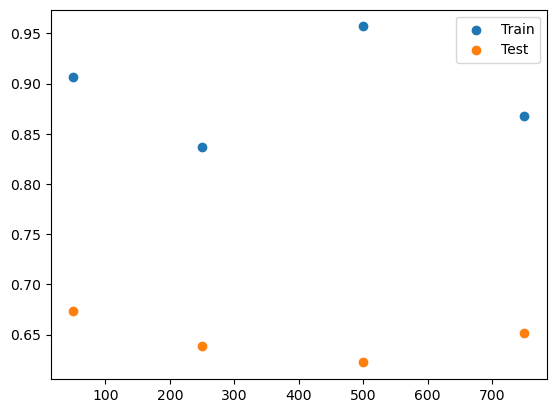

In [71]:
fig, ax = plt.subplots()
ax.scatter(results['n_questions'], results['f1_train'], color='C0', label='Train')
ax.scatter(results['n_questions'], results['f1_test'], color='C1', label='Test')
plt.legend()
plt.show()

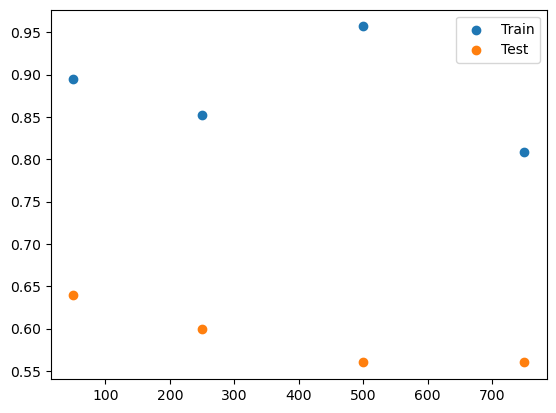

In [75]:

fig, ax = plt.subplots()
ax.scatter(results['n_questions'], results['Recall_train'], color='C0', label='Train')
ax.scatter(results['n_questions'], results['Recall_test'], color='C1', label='Test')
plt.legend()
plt.show()

In [49]:

batch = next(iter(train_dataloader))        

inputs, labels = batch

input_year, input_seq = inputs
bs, ss = labels.size(0), 14
print(input_seq.shape)
input_seq = input_seq.reshape(bs * ss, -1)

print(input_seq.shape)


torch.Size([16, 14, 385])
torch.Size([224, 385])


In [52]:
next(iter(train_dataloader))[0][1].shape[-1]


385